<center>
<img src="../../img/ods_stickers.jpg">
## Открытый курс по машинному обучению
</center>
Авторы материала: Data Science интерн Ciklum, студент магистерской программы CSDS UCU Виталий Радченко, программист-исследователь Mail.ru Group, старший преподаватель Факультета Компьютерных Наук ВШЭ Юрий Кашницкий. Материал распространяется на условиях лицензии [Creative Commons CC BY-NC-SA 4.0](https://creativecommons.org/licenses/by-nc-sa/4.0/). Можно использовать в любых целях (редактировать, поправлять и брать за основу), кроме коммерческих, но с обязательным упоминанием автора материала.

# <center> Тема 5. Композиции алгоритмов, случайный лес</center>
## <center> Часть 1. Bagging</center>

Из прошлых лекций вы уже узнали про разные алгоритмы классификации, а также научились правильно валидироваться и оценивать качество модели. Но что делать, если вы уже нашли лучшую модель и повысить точность модели больше не можете? В таком случае нужно применить более продвинутые техники машинного обучения, которые можно объединить словом «ансамбли». Ансамбль — это некая совокупность, части которой образуют единое целое. Из повседневной жизни вы знаете музыкальные ансамбли, где объединены несколько музыкальных инструментов, архитектурные ансамбли с разными зданиями и т.д.

### Ансамбли

Хорошим примером ансамблей считается теорема Кондорсе «о жюри присяжных» (1784). Если каждый член жюри присяжных имеет независимое мнение, и если вероятность правильного решения члена жюри больше 0.5, то тогда вероятность правильного решения присяжных в целом возрастает с увеличением количества членов жюри и стремится к единице. Если же вероятность быть правым у каждого из членов жюри меньше 0.5, то вероятность принятия правильного решения присяжными в целом монотонно уменьшается и стремится к нулю с увеличением количества присяжных.
- $\large N $ — количество присяжных
- $\large p $ — вероятность правильного решения присяжного
- $\large \mu $ — вероятность правильного решения всего жюри
- $\large m $ — минимальное большинство членов жюри, $ m = floor(N/2) + 1 $
- $\large C_N^i$ — число [сочетаний](https://ru.wikipedia.org/wiki/%D0%A1%D0%BE%D1%87%D0%B5%D1%82%D0%B0%D0%BD%D0%B8%D0%B5) из $N$ по $i$
$$ \large \mu = \sum_{i=m}^{N}C_N^ip^i(1-p)^{N-i} $$
Если $\large p > 0.5 $, то $\large \mu > p $
Если $\large N \rightarrow \infty $, то $\large \mu \rightarrow 1 $
<img src="../../img/bull.png" align="right" width=15% height=15%>
Давайте рассмотрим ещё один пример ансамблей — "Мудрость толпы". Фрэнсис Гальтон в 1906 году посетил рынок, где проводилась некая лотерея для крестьян.
Их собралось около 800 человек и они пытались угадать вес быка, который стоял перед ними. Его вес составлял 1198 фунтов. Ни один крестьянин не угадал точный вес быка, но если посчитать среднее от их предсказаний, то получим 1197 фунтов.
Эту идею уменьшения ошибки применили и в машинном обучении.


### Бутстрэп

Bagging (от Bootstrap aggregation) — это один из первых и самых простых видов ансамблей. Он был придуман [Ле́о Бре́йманом](https://ru.wikipedia.org/wiki/Брейман,_Лео) в 1994 году. Бэггинг основан на статистическом методе бутстрэппинга, который позволяет оценивать многие статистики сложных моделей.

Метод бутстрэпа заключается в следующем. Пусть имеется выборка $\large X$ размера $\large N$. Равномерно возьмем из выборки $\large N$ объектов с возвращением. Это означает, что мы будем $\large N$ раз выбирать произвольный объект выборки (считаем, что каждый объект «достается» с одинаковой вероятностью $\large \frac{1}{N}$), причем каждый раз мы выбираем из всех исходных $\large N$ объектов. Можно представить себе мешок, из которого достают шарики: выбранный на каком-то шаге шарик возвращается обратно в мешок, и следующий выбор опять делается равновероятно из того же числа шариков. Отметим, что из-за возвращения среди них окажутся повторы. Обозначим новую выборку через $\large X_1$. Повторяя процедуру $\large M$ раз, сгенерируем $\large M$ подвыборок $\large X_1, \dots, X_M$. Теперь мы имеем достаточно большое число выборок и можем оценивать различные статистики исходного распределения.

![image](../../img/bootstrap.jpg)

Давайте для примера возьмем вам уже известный датасет `telecom_churn` из прошлых уроков нашего курса. Напомним, что это задача бинарной классификации оттока клиентов. Одним из самых важных признаков в этом датасете является количество звонков в сервисный центр, которые были сделаны клиентом. Давайте попробуем визулизировать данные и посмотреть на распределение данного признака.



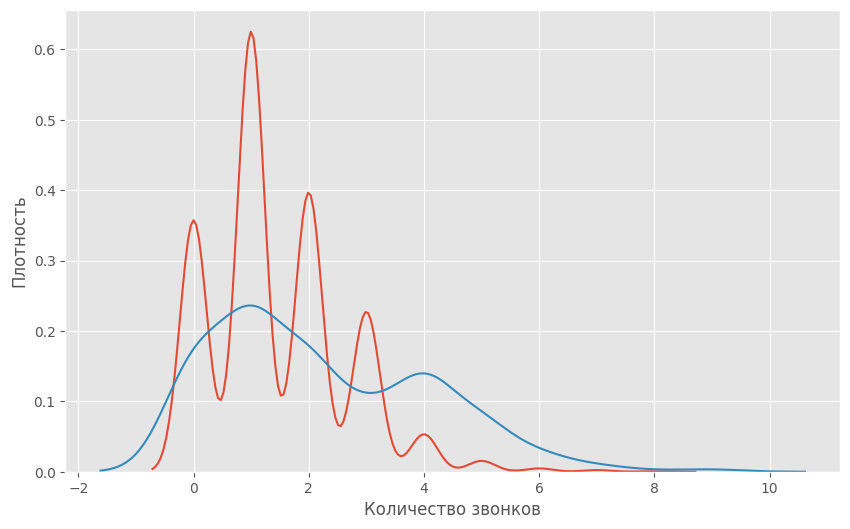

In [1]:
import pandas as pd
from matplotlib import pyplot as plt

plt.style.use("ggplot")
plt.rcParams["figure.figsize"] = 10, 6
import seaborn as sns

%matplotlib inline

# telecom_data = pd.read_csv("../../data/telecom_churn.csv")
telecom_data = pd.read_csv('https://github.com/Yorko/mlcourse.ai/raw/main/data/telecom_churn.csv')

fig = sns.kdeplot(
    telecom_data[telecom_data["Churn"] == False]["Customer service calls"],
    label="Loyal",
)
fig = sns.kdeplot(
    telecom_data[telecom_data["Churn"] == True]["Customer service calls"], label="Churn"
)
fig.set(xlabel="Количество звонков", ylabel="Плотность")
plt.show()

Как вы уже могли заметить, количество звонков в сервисный центр у лояльных клиентов меньше, чем у наших бывших клиентов. Теперь было бы хорошо оценить сколько в среднем делает звонков каждая из групп. Так как данных в нашем датасете мало, то искать среднее не совсем правильно, лучше применить наши новые знания бутстрэпа. Давайте сгенерируем 1000 новых подвыборок из нашей генеральной совокупности и сделаем интервальную оценку среднего.

In [2]:
import numpy as np


def get_bootstrap_samples(data, n_samples):
    # функция для генерации подвыборок с помощью бутстрэпа
    indices = np.random.randint(0, len(data), (n_samples, len(data)))
    samples = data[indices]
    return samples


def stat_intervals(stat, alpha):
    # функция для интервальной оценки
    boundaries = np.percentile(stat, [100 * alpha / 2.0, 100 * (1 - alpha / 2.0)])
    return boundaries


# сохранение в отдельные numpy массивы данных по лояльным и уже бывшим клиентам
loyal_calls = telecom_data[telecom_data["Churn"] == False][
    "Customer service calls"
].values
churn_calls = telecom_data[telecom_data["Churn"] == True][
    "Customer service calls"
].values

# ставим seed для воспроизводимости результатов
np.random.seed(0)

# генерируем выборки с помощью бутстрэра и сразу считаем по каждой из них среднее
loyal_mean_scores = [
    np.mean(sample) for sample in get_bootstrap_samples(loyal_calls, 1000)
]
churn_mean_scores = [
    np.mean(sample) for sample in get_bootstrap_samples(churn_calls, 1000)
]

#  выводим интервальную оценку среднего
print(
    "Service calls from loyal:  mean interval", stat_intervals(loyal_mean_scores, 0.05)
)
print(
    "Service calls from churn:  mean interval", stat_intervals(churn_mean_scores, 0.05)
)

Service calls from loyal:  mean interval [1.4077193  1.49473684]
Service calls from churn:  mean interval [2.0621118  2.39761905]



В итоге мы получили, что с 95% вероятностью среднее число звонков от лояльных клиентов будет лежать в промежутке между 1.40 и 1.50, в то время как наши бывшие клиенты звонили в среднем от 2.06 до 2.40 раз. Также ещё можно обратить внимание, что интервал для лояльных клиентов уже, что довольно логично, так как они звонят редко (в основном 0, 1 или 2 раза), а недовольные клиенты будут звонить намного чаще, но со временем их терпение закончится, и они поменяют оператора.

### Бэггинг


Теперь вы имеете представление о бустрэпе, и мы можем перейти непосредственно к бэггингу. Пусть имеется обучающая выборка $\large X$. С помощью бутстрэпа сгенерируем из неё выборки $\large X_1, \dots, X_M$. Теперь на каждой выборке обучим свой классификатор $\large a_i(x)$. Итоговый классификатор будет усреднять ответы всех этих алгоритмов (в случае классификации это соответствует голосованию): $\large a(x) = \frac{1}{M}\sum_{i = 1}^M a_i(x)$. Эту схему можно представить картинкой ниже.

<img src="../../img/bagging.png" alt="image"/>

Рассмотрим задачу регрессии с базовыми алгоритмами $\large b_1(x), \dots , b_n(x)$. Предположим, что существует истинная функция ответа для всех объектов $\large y(x)$, а также задано распределение на объектах $\large p(x)$. В этом случае мы можем записать ошибку каждой функции регрессии $$ \large \varepsilon_i(x) = b_i(x) − y(x),  i = 1, \dots, n$$

и записать матожидание среднеквадратичной ошибки $$ \large E_x(b_i(x) − y(x))^{2} = E_x [\varepsilon_i^2 (x)]. $$

Средняя ошибка построенных функций регрессии имеет вид $$ \large E_1 = \frac{1}{n}E_x \sum_{i=1}^n \varepsilon_i^{2}(x) $$

Предположим, что ошибки несмещены и некоррелированы:

$$ \large \begin{array}{rcl} E_x\varepsilon_i(x) &=& 0, \\
E_x\varepsilon_i(x)\varepsilon_j(x) &=& 0, i \neq j. \end{array}$$

Построим теперь новую функцию регрессии, которая будет усреднять ответы построенных нами функций:
$$ \large a(x) = \frac{1}{n}\sum_{i=1}^{n}b_i(x) $$

Найдем ее среднеквадратичную ошибку:

$$ \large \begin{array}{rcl}E_n &=& E_x\Big(\frac{1}{n}\sum_{i=1}^{n}b_i(x)-y(x)\Big)^2 \\
&=& E_x\Big(\frac{1}{n}\sum_{i=1}^{n}\varepsilon_i\Big)^2 \\
&=& \frac{1}{n^2}E_x\Big(\sum_{i=1}^{n}\varepsilon_i^2(x) + \sum_{i \neq j}\varepsilon_i(x)\varepsilon_j(x)\Big) \\
&=& \frac{1}{n}E_1\end{array}$$

Таким образом, усреднение ответов позволило уменьшить средний квадрат ошибки в n раз!

Напомним вам из нашего предыдущего [урока](https://habrahabr.ru/company/ods/blog/323890/#razlozhenie-oshibki-na-smeschenie-i-razbros-bias-variance-decomposition), как раскладывается общая ошибка:
$$\large \begin{array}{rcl}
\text{Err}\left(\vec{x}\right) &=& \mathbb{E}\left[\left(y - \hat{f}\left(\vec{x}\right)\right)^2\right] \\
&=& \sigma^2 + f^2 + \text{Var}\left(\hat{f}\right) + \mathbb{E}\left[\hat{f}\right]^2 - 2f\mathbb{E}\left[\hat{f}\right] \\
&=& \left(f - \mathbb{E}\left[\hat{f}\right]\right)^2 + \text{Var}\left(\hat{f}\right) + \sigma^2 \\
&=& \text{Bias}\left(\hat{f}\right)^2 + \text{Var}\left(\hat{f}\right) + \sigma^2
\end{array}$$

Бэггинг позволяет снизить дисперсию (variance) обучаемого классификатора, уменьшая величину, на сколько ошибка будет отличаться, если обучать модель на разных наборах данных, или другими словами, предотвращает переобучение. Эффективность бэггинга достигается благодаря тому, что базовые алгоритмы, обученные по различным подвыборкам, получаются достаточно различными, и их ошибки взаимно компенсируются при голосовании, а также за счёт того, что объекты-выбросы могут не попадать в некоторые обучающие подвыборки.

В библиотеке `scikit-learn` есть реализация `BaggingRegressor` и `BaggingClassifier`, которая позволяет использовать большинство других алгоритмов "внутри". Рассмотрим на практике как работает бэггинг и сравним его с деревом решений, воспользуясь примером из [документации](http://scikit-learn.org/stable/auto_examples/ensemble/plot_bias_variance.html#sphx-glr-auto-examples-ensemble-plot-bias-variance-py).

![image](../../img/tree_vs_bagging.png)

Ошибка дерева решений
$$ \large 0.0255 (Err) = 0.0003 (Bias^2)  + 0.0152 (Var) + 0.0098 (\sigma^2) $$
Ошибка бэггинга
$$ \large 0.0196 (Err) = 0.0004 (Bias^2)  + 0.0092 (Var) + 0.0098 (\sigma^2) $$

По графику и результатам выше видно, что ошибка дисперсии намного меньше при бэггинге, как мы и доказали теоретически выше.

Бэггинг эффективен на малых выборках, когда исключение даже малой части обучающих объектов приводит к построению существенно различных базовых классификаторов. В случае больших выборок обычно генерируют подвыборки существенно меньшей длины.

Следует отметить, что рассмотренный нами пример не очень применим на практике, поскольку мы сделали предположение о некоррелированности ошибок, что редко выполняется. Если это предположение неверно, то уменьшение ошибки оказывается не таким значительным. В следующих лекциях мы рассмотрим более сложные методы объединения алгоритмов в композицию, которые позволяют добиться высокого качества в реальных задачах.

### Out-of-bag error

Забегая вперед, отметим, что при использовании случайных лесов нет необходимости в кросс-валидации или в отдельном тестовом наборе, чтобы получить несмещенную оценку ошибки набора тестов. Внутренняя оценка во время работы получается следующим образом:

Каждое дерево строится с использованием разных образцов бутстрэпа из исходных данных. Примерно 37% примеров остаются вне выборки бутстрэпа и не используется при построении k-го дерева.

Это можно легко доказать: пусть в выборке $\large \ell$ объектов. На каждом шаге все объекты попадают в подвыборку с возвращением равновероятно, т.е отдельный объект — с вероятностью  $\large\frac{1}{\ell}.$ Вероятность того, что объект НЕ попадет в подвыборку (т.е. его не взяли $\large \ell$ раз): $\large (1 - \frac{1}{\ell})^\ell$. При $\large \ell \rightarrow +\infty$ получаем один из "замечательных" пределов $\large \frac{1}{e}$. Тогда вероятность попадания конкретного объекта в подвыборку $\large \approx  1 - \frac{1}{e} \approx 63\%$.

Давайте рассмотрим, как это работает на практике:

![image](../../img/oob.png)
На рисунке видно, что наш классификатор ошибся в 4 наблюдениях, которые мы не использовали для тренировки. Значит точность нашего классификатора: $\large \frac{11}{15}*100\% = 73.33\%$

Получается, что каждый базовый алгоритм обучается на ~63% исходных объектов. Значит, на оставшихся ~37% его можно сразу проверять. Out-of-Bag оценка — это усредненная оценка базовых алгоритмов на тех ~37% данных, на которых они не обучались.